In [ ]:
def mylaplacepoisson1(psi, w, psin, wn, pl1_target, wl1_target):
    
    iterations = 0
    
    witer_diff = wl1_target+1 #init iter_diff to be larger than l2_target
    wdenominator = 0.0
    
    piter_diff = pl1_target+1 #init iter_diff to be larger than l2_target
    pdenominator = 0.0
    
    ny, nx = w.shape                                            # psi.shape????
    wl1_diff = numpy.zeros(20000)
    pl1_diff = numpy.zeros(20000)
    
    while (witer_diff > wl1_target and piter_diff > pl1_target):
        
        for j in range(ny):
            for i in range(nx):
                wn[j,i] = w[j,i]
                psin[j,i] = psi[j,i] 
        
        witer_diff = 0.0
        wdenominator = 0.0
        
        piter_diff = 0.0
        pdenominator = 0.0
        
        for j in range (1,ny-1):
            for i in range (1,nx-1):
                w[j,i] = .25 * (w[j,i-1] + w[j,i+1] + w[j-1,i] + w[j+1,i])
                psi[j,i] = 1/(2*(dx**2 + dy**2)) * \
                        ((psi[j,i+1] + psi[j,i-1])*dy**2 +\
                        (psi[j+1,i] + psi[j-1,i])*dx**2 +\
                         w[j,i]*dx**2*dy**2)
                
                
        #Neumann 2nd-order BC
        
        for i in range(1,nx-1):
            w[-1,i] = ((-1/(2*dy**2)) * (8*psi[-2,i] - psi[-3,i] - 7*psi[-1,i])) - 3/dy #7 psi pas dans l'énoncé?????
            psi[1,i] = 0
        for j in range (1,ny-1):
            psi[j,1] = 0
            psi[j,-2] = 0
        
        for j in range(ny):
            for i in range(nx):
                witer_diff += (w[j,i] - wn[j,i])**2
                wdenominator += (wn[j,i]*wn[j,i])
                piter_diff += (psi[j,i] - psin[j,i])**2
                pdenominator += (psin[j,i]*psin[j,i])
        
        witer_diff /= wdenominator
        witer_diff = witer_diff**0.5
        wl1_diff[iterations] = witer_diff
        piter_diff /= pdenominator
        piter_diff = piter_diff**0.5
        pl1_diff[iterations] = piter_diff
        iterations += 1    
        
    return psi, w, iterations, pl1_diff, wl1_diff

In [8]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [9]:
import numba
from numba import jit

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [11]:
def plot_3D(x, y, psi):
    '''Creates 3D plot with appropriate limits and viewing angle
    
    Parameters:
    ----------
    x: array of float
        nodal coordinates in x
    y: array of float
        nodal coordinates in y
    psi: 2D array of float
        calculated potential field
    
    '''
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,psi[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.view_init(30,45)

In [12]:
nx = 41
ny = 41
l = 1.
h = 1.
dx = l/(nx-1)
dy = h/(ny-1)
l1_target = 1e-6
x = numpy.linspace(0,l,nx)
y = numpy.linspace(0,h,ny)
psi0 = numpy.zeros((ny,nx))
w0 = numpy.zeros((ny,nx))




In [22]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

In [23]:
def mylaplacepoisson(psi, w, psi_n, w_n, l1_target):
    
    iterations = 0
    normw = l1_target+1 #init normw to be larger than l1_target
    normpsi = l1_target+1 #init normpsi to be larger than l1_target
   
    while (normw > l1_target and normpsi > l1_target):
        for j in range(ny):
            for i in range(nx):
                w_n[j,i] = w[j,i]
                psi_n[j,i] = psi[j,i]
        
        
        for j in range (1,ny-1):
            for i in range (1,nx-1):
                w[j,i] = .25 * (w_n[j,i-1] + w_n[j,i+1] + w_n[j-1,i] + w_n[j+1,i])
                psi[j,i] = 1/(2*(dx**2 + dy**2)) * \
                        ((psi_n[j,i+1] + psi_n[j,i-1])*dy**2 +\
                        (psi_n[j+1,i] + psi_n[j-1,i])*dx**2 +\
                         w_n[j,i]*dx**2*dy**2)
         
        #Neumann 2nd-order BC
       
        for j in range (1,ny-1):
            psi[j,1] = psi[j,0]
            psi[j,-2] = psi[j,-1]
        for i in range(1,nx-1):
            psi[1,i] = psi[0,i]
            w[-1,i] = ((-1/(2*dy**2)) * (8*psi_n[-2,i] - psi_n[-3,i] - 7*psi[-1,i] )) - 3/dy #7*psi pas dans l'énoncé?????
        
        norm =  L1norm(w_n, w)
        normw = norm
        norm = L1norm(psi_n, psi)
        normpsi = norm
    
        iterations += 1
       
        
    return psi, w, iterations, normw, normpsi

In [24]:
psi, w, iterations, normw, normpsi = mylaplacepoisson(psi0, w0, psi0, w0, l1_target)

In [25]:
print (iterations)

1


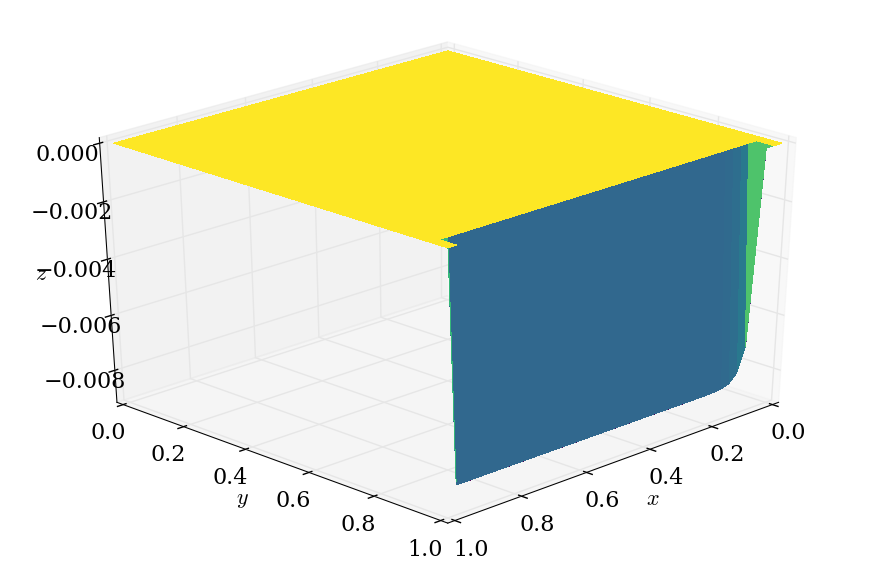

In [26]:
plot_3D(x,y,psi)